<a href="https://colab.research.google.com/github/RoseVZ/Pepper-Leaf-Disease-Classifiaction/blob/main/plant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras import models , layers
import matplotlib.pyplot as plt


In [50]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [51]:
!ls "/content/drive/My Drive"

'Colab Notebooks'   plant   plant.ipynb   plant.zip


In [22]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS= 3
EPOCHS=10

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/My Drive/plant",
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE

)

Found 2475 files belonging to 2 classes.


In [6]:
class_names=dataset.class_names
class_names

['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy']

In [7]:
len(dataset)

78

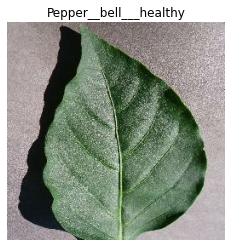

In [25]:
for image_batch, label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype('uint8'))
    plt.title(class_names[label_batch[0]])
    plt.axis('off')
   


In [9]:
def get_dataset_partitions_tf(ds, train_split = 0.8 ,test_split= 0.1, val_split=0.1, shuffle=True,shuffle_size=10000):
        train_size = int(len(ds)*train_split)
        val_size = int(len(ds)*val_split)
        test_size = int(len(ds)*test_split)
        if shuffle:
            ds=ds.shuffle(shuffle_size,seed=12)
        
        train_ds = ds.take(train_size)
        val_ds = ds.skip(train_size).take(val_size)
        test_ds = ds.skip(train_size).skip(val_size).take(test_size)
        return train_ds,val_ds, test_ds
    

In [10]:
#train test validation split
train_ds,val_ds,test_ds= get_dataset_partitions_tf(dataset)

In [11]:
len(train_ds)

62

In [12]:
len(val_ds)

7

In [13]:
len(test_ds)

7

In [14]:
#prefetch and cache
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [15]:
# Scaling the images to a value between 0 & 1(originally 0-255)
# Resizing all the images to a given image size

resize_rescale= tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255),
])

In [16]:
#Data Augmentation layer

data_augumentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [17]:
n_classes=2
input_shape =(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
model=models.Sequential([
    resize_rescale,
    data_augumentation,
    layers.Conv2D(32,(3,3),activation='relu' ,input_shape =input_shape),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(32,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(32,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D(2,2),
    #flatten the network to a straight 1D
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax')
               
                  
])
model.build(input_shape=input_shape)

In [18]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 32)         0         
 2D)                                                  

In [19]:
model.compile(
               optimizer='adam',
              loss= tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, reduction="auto", name="sparse_categorical_crossentropy"
),
              metrics=['accuracy'],
)

In [23]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    verbose=1,
    epochs=EPOCHS,
    validation_data=val_ds,

)

Epoch 1/10
62/62 [==============================] - 156s 3s/step - loss: 0.0897 - accuracy: 0.9730 - val_loss: 0.2641 - val_accuracy: 0.9420
Epoch 2/10
62/62 [==============================] - 155s 2s/step - loss: 0.0956 - accuracy: 0.9684 - val_loss: 0.0919 - val_accuracy: 0.9777
Epoch 3/10
62/62 [==============================] - 154s 2s/step - loss: 0.0542 - accuracy: 0.9868 - val_loss: 0.0935 - val_accuracy: 0.9643
Epoch 4/10
62/62 [==============================] - 156s 3s/step - loss: 0.0406 - accuracy: 0.9873 - val_loss: 0.0241 - val_accuracy: 0.9911
Epoch 5/10
62/62 [==============================] - 155s 3s/step - loss: 0.0330 - accuracy: 0.9893 - val_loss: 0.0478 - val_accuracy: 0.9821
Epoch 6/10
62/62 [==============================] - 150s 2s/step - loss: 0.0204 - accuracy: 0.9924 - val_loss: 0.0410 - val_accuracy: 0.9821
Epoch 7/10
62/62 [==============================] - 150s 2s/step - loss: 0.0397 - accuracy: 0.9888 - val_loss: 0.0185 - val_accuracy: 0.9955
Epoch 8/10
62

In [24]:
scores = model.evaluate(test_ds)

7/7 [==============================] - 12s 840ms/step - loss: 0.0157 - accuracy: 0.9911


In [26]:
history.params

{'epochs': 10, 'steps': 62, 'verbose': 1}

In [28]:
import numpy as np


In [33]:
def predict(img,model):
    image_array= tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    image_array=tf.expand_dims(image_array,0)
    prediction=model.predict(image_array)
    class_predict = class_names[np.argmax(prediction[0])]
    confidence = round(100*np.max(prediction[0]),3)
    return class_predict, confidence

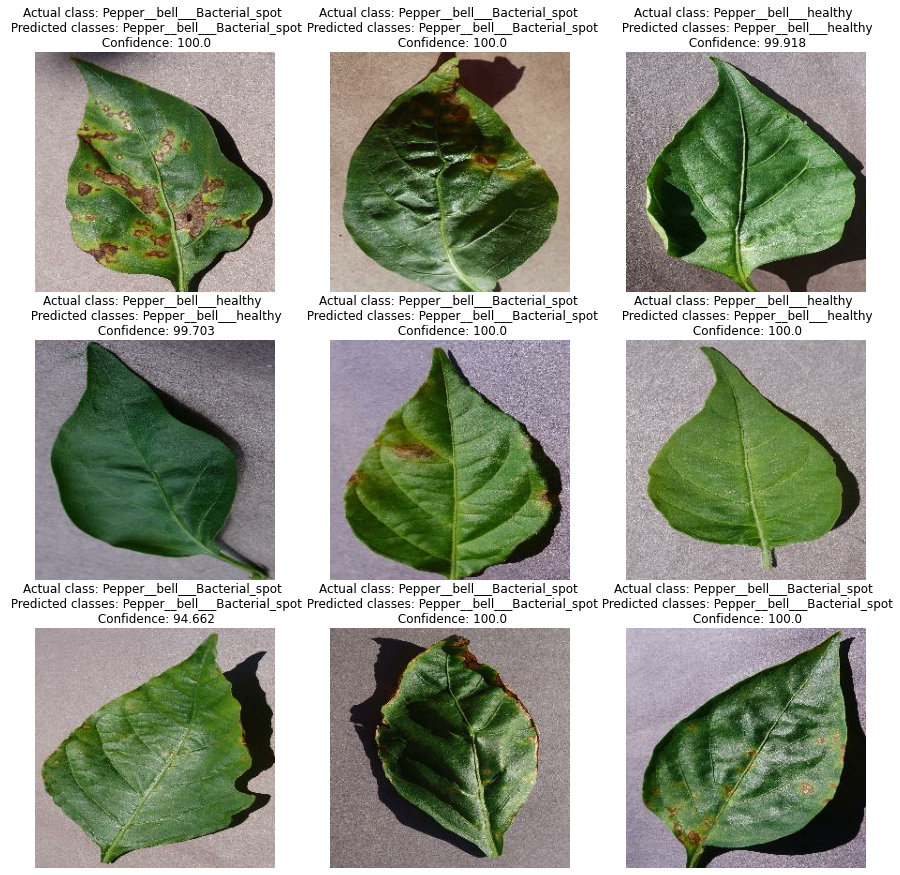

In [34]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.axis("off")
    plt.imshow(images[i].numpy().astype('uint8'))
    predicted_class, confidence=predict(images[i].numpy(),model)
    actual_class = class_names[labels[i]]
    plt.title(f"Actual class: {actual_class} \n Predicted classes: {predicted_class}\n Confidence: {confidence}")

  